## Swaption Approximation

Swaption implied Black volatility approximation comparison based on Piterbarg (Vol 2, chpt 13) and Chibane- 2012

In [1]:
import os
import sys

In [2]:
current_dir = os.getcwd()
qg_dir = os.path.join(current_dir, "..")

sys.path.append(qg_dir)

In [3]:
import sys
import os
import sys
import os
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['text.usetex'] = True
from quassigaussian.finitedifference.mesher.linear_mesher import extract_x0_result

In [4]:
from quassigaussian.parameters.volatility.local_volatility import LinearLocalVolatility
from quassigaussian.products.instruments import Swap, Swaption
from quassigaussian.curves.libor import LiborCurve
import pandas as pd
import os
from report.directories import output_data_raw, date_timestamp
from quassigaussian.products.pricer import  SwapPricer
from report.utils import get_nonexistant_path
from quassigaussian.fastswaptionsolver.discrete_averaging import DiscreteParameterAveraging
from quassigaussian.fastswaptionsolver.numerical_integration import PitergargDiscreteXY, RungeKuttaApproxXY
from quassigaussian.fastswaptionsolver.parameter_averaging import lognormalimpliedvola


In [5]:
#20Y1Y swaption
swaption_expiry=20
swap_maturity = 21

swap_freq = 0.5
curve_rate = 0.06

kappa = 0.03
theta = 1/2
initial_curve = LiborCurve.from_constant_rate(curve_rate)




t_max = swap_maturity
t_min = 0

#### Comparison for various volatility levels

In [6]:
########## Compare results for different volatility levels ###############
#loca_vola = LinearLocalVolatility.from_const(swap_maturity, 0.7, 0.06, 0.2)
loca_vola = LinearLocalVolatility.from_const(swap_maturity, 0.4, 0.06, 0.1)

In [7]:
swap_pricer = SwapPricer(initial_curve, kappa)


In [8]:
swap = Swap(swaption_expiry, swap_maturity, swap_freq)
coupon_grid = [0, +0.005, -0.005, +0.01, -0.01, 0.015, -0.015]

atm_swap_price = swap_pricer.price(swap, 0, 0, 0)
strike_grid = [atm_swap_price + coupon for coupon in coupon_grid]



In [9]:
# integration grid size for parameter averaging intervals
integration_grid_size = 2**12 + 1


In [10]:
def calculate_implied_vola(XYApproximator):
    
    xy_calculator = XYApproximator(integration_grid_size, swap_pricer, loca_vola, swap)
    integration_approx = DiscreteParameterAveraging(integration_grid_size, swap_pricer, loca_vola, swap, xy_calculator)
    lambda_avg, beta_avg = integration_approx.calculate_average_param()
    all_output_data_ls = []
    
    for strike in strike_grid:
        swaption = Swaption(swaption_expiry, strike, swap)
        swaption_value, black_implied_vola = lognormalimpliedvola(swaption, swap_pricer, lambda_avg,
                                                                  beta_avg)

        output_data = pd.DataFrame({"atm strike": atm_swap_price, "swaption_value":[swaption_value],
                                    "kappa": [kappa], "strike": [strike],
                                    'moneyness': [strike-atm_swap_price],
                                    "implied_black_vola": black_implied_vola,
                                     "xy_approximation": [str(xy_calculator)]})
        all_output_data_ls.append(output_data)
    all_output_data_df = pd.concat(all_output_data_ls)
    return all_output_data_df.sort_values("moneyness")

In [11]:
# Two types of approximator: 

# Based on Piterbarg (Chpt 13, vol 2) - Method A
implied_vola_df_piterbarg = calculate_implied_vola(PitergargDiscreteXY)

# Chibane 2012 - Method B
implied_vola_df_rg = calculate_implied_vola(RungeKuttaApproxXY)


Text(0.5, 1.0, '20Y1Y swaption approximation comparison')

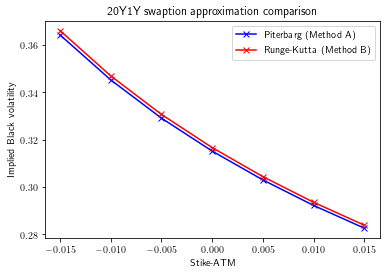

In [12]:
plt.plot(implied_vola_df_piterbarg["moneyness"], implied_vola_df_piterbarg["implied_black_vola"], "b-x", label="Piterbarg (Method A)")
plt.plot(implied_vola_df_rg["moneyness"], implied_vola_df_rg["implied_black_vola"], "r-x", label="Runge-Kutta (Method B)")
plt.legend()
plt.xlabel("Stike-ATM")
plt.ylabel("Implied Black volatility")
plt.title("{}Y{}Y swaption approximation comparison".format(swaption_expiry, swap_maturity-swaption_expiry))